# <div class="alert alert-info"> 1. ARIMA </div>

## <font color=red>1.1. Introduction</font>

The general process for ARIMA model is the following:
+ Visualize the time series data
+ Make the time series data stationary
+ Plot the Correlation and AutoCorrelation Charts
+ Construct the ARIMA Model
+ Use the model to make predictions

---
# <div class="alert alert-info"> 2. Setup </div>

 ## <font color=red>2.1. Import library</font>

In [119]:
import quandl
import warnings
import itertools
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import the models we'll be using in this section
from statsmodels.tsa.stattools import ccovf,ccf
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse, rmse, meanabs

from sklearn.model_selection import TimeSeriesSplit

 ## <font color=red>2.2. Configuration</font>

In [120]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 505)

---
# <div class="alert alert-info"> 3. Data Preparation </div>

 ## <font color=red>3.1.  Load data</font>

In [121]:
df = pd.read_csv('Data/airline_passengers.csv', index_col='Month', parse_dates=True)
df.index.freq = 'MS'
print(df.shape)
df.head()

(144, 1)


,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Thousands of Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


---
# <div class="alert alert-info"> 4. Preliminary Analysis </div>

To explore the dataset:
+ Are there consisten patterns?
+ Is there a significant trend?
+ Is seasonality important?
+ Is there evidence of the presence of business cycles?
+ Are there any outliers in the data that need to be explained by those with expert knowledge?

### <font color=blue> 4.  Time Series Analysis Plots

In [123]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags = None, figsize=(12,8), style = 'bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))
        
        y.plot(ax = ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags = lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags = lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    
    return

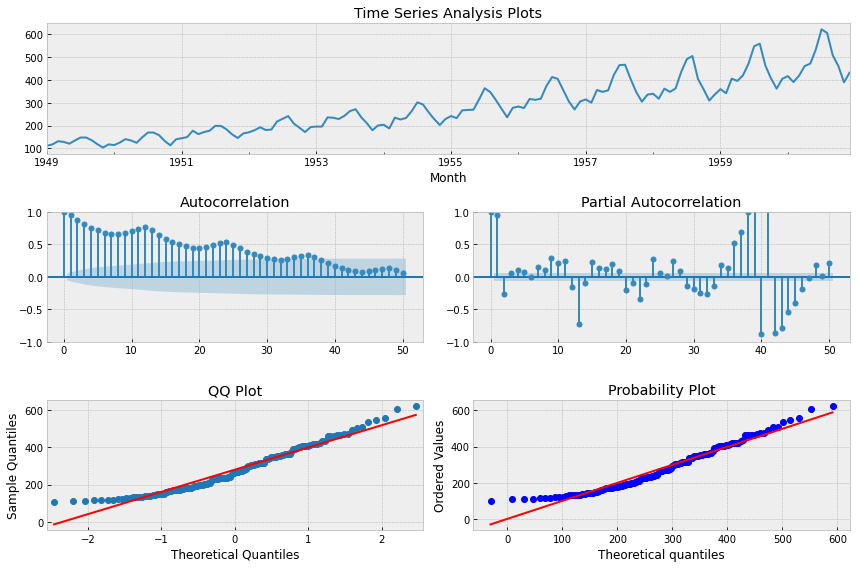

In [124]:
tsplot(df['Thousands of Passengers'], lags=50)

---
# <div class="alert alert-info"> 6. Build ARIMA model </div>

## <font color=red> 6.1. Introduction
    
<strong>ARIMA</strong>, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of AR model and MA model with a differenced series:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period. It is the correlation a current time series with a lagged version of the same series.

    
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary. We apply differencing to make a time series stationary, which ARIMA requires.

    
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. Can be found using SMA, EWMA or Holt-Winters Method
    
Thus, for a stationary time series ARIMA models combine autoregression and moving average concepts to model the behavior of a long running time series and helps in forecasting.

**Example**:
Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ (phi-sub-one) is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

ARMA models can be used on stationary datasets.

For non-stationary datasets with a trend component, ARIMA models apply a differencing coefficient as well.

Once we understand the components, we'll investigate how to best choose the $p$, $d$ and $q$ values required by the model.

## <font color=red> 6.5. ARIMA

In [125]:
ts_data = df['Thousands of Passengers']
# split data into 2 sets: train set and test set
size = int(len(ts_data) - 25)
train, test = ts_data[0:size], ts_data[size:len(ts_data.values)]

### <font color=blue> 1. Train the model

In [126]:
model = sm.tsa.ARIMA(train, order=(12,2,2))
results_ARIMA = model.fit()

### <font color=blue>2. Print the results of the ARIMA model

In [127]:
print(results_ARIMA.summary())

                                  SARIMAX Results                                  
Dep. Variable:     Thousands of Passengers   No. Observations:                  119
Model:                     ARIMA(12, 2, 2)   Log Likelihood                -445.527
Date:                     Wed, 20 Jul 2022   AIC                            921.053
Time:                             01:35:55   BIC                            962.486
Sample:                         01-01-1949   HQIC                           937.874
                              - 11-01-1958                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0617      0.195     -0.316      0.752      -0.444       0.320
ar.L2         -0.1700      0.136     -1.251      0.211      -0.436       0.096
ar.L3       

### <font color=blue> 3. Plot results

[]

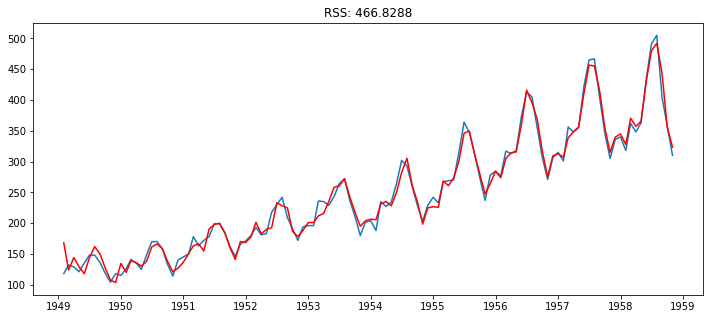

In [128]:
plt.figure(figsize=(12,5))
plt.plot(train.index[1:].to_pydatetime(), train.values[1:])
plt.plot(train.index[1:].to_pydatetime(), results_ARIMA.fittedvalues[1:], color='red')
plt.title('RSS: %.4f'% sum(results_ARIMA.fittedvalues[1:] - train.values[1:]) ** 2)
plt.plot()

#### Plot residual errors

                0
count  119.000000
mean     0.759612
std     15.244900
min    -50.026586
25%     -6.262913
50%     -0.747366
75%      7.553787
max    112.000000


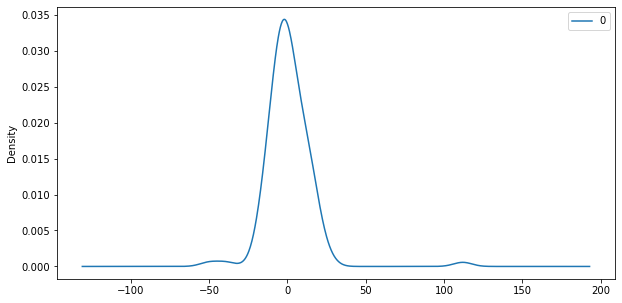

In [129]:
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde', figsize=(10,5))
print(residuals.describe())

### <font color=blue> 4. Perform and visualize test set

In [130]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results_ARIMA.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(12,2,2) Predictions')

In [131]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test[i]}")

predicted=341.82104995960754, expected=337
predicted=349.986558141945, expected=360
predicted=326.43728986042, expected=342
predicted=369.05793719859804, expected=406
predicted=353.83616189342285, expected=396
predicted=378.9115228729701, expected=420
predicted=447.5122990989045, expected=472
predicted=507.9712198523158, expected=548
predicted=518.6530978851785, expected=559
predicted=427.8914633398192, expected=463
predicted=381.26942123061474, expected=407
predicted=336.4917276149914, expected=362
predicted=366.07261997162993, expected=405
predicted=373.0055476798319, expected=417
predicted=348.5770449790083, expected=391
predicted=385.7242807455453, expected=419
predicted=370.3516985535198, expected=461
predicted=401.0698196413561, expected=472
predicted=467.5716183328981, expected=535
predicted=529.3645855191717, expected=622
predicted=537.9859045753825, expected=606
predicted=454.63857831813107, expected=508
predicted=407.6694291421397, expected=461
predicted=365.42129761142394, e

[]

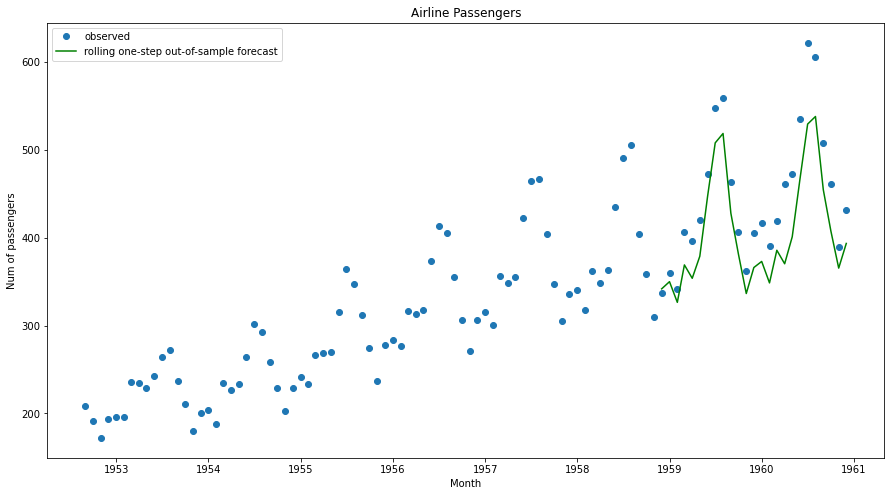

In [132]:
# visualize time series forecast
predictions_series = pd.Series(predictions, index = test.index)
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title='Airline Passengers', xlabel='Month', ylabel='Num of passengers')
ax.plot(ts_data[-100:], 'o', label='observed')
ax.plot(predictions_series, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.plot()

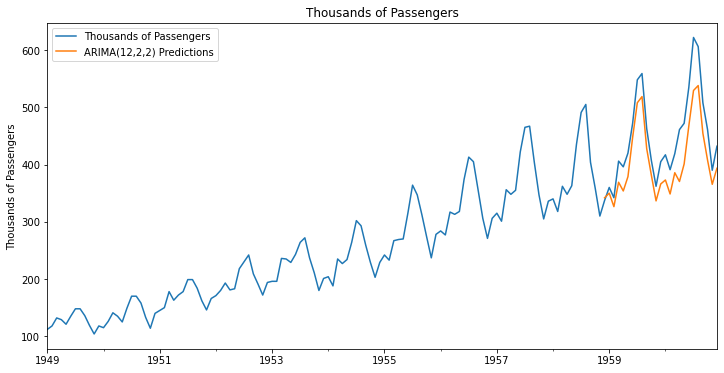

In [133]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'Thousands of Passengers'
ylabel='Thousands of Passengers'
xlabel='' # we don't really need a label here

ax = df['Thousands of Passengers'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### <font color=blue>5. Evaluate the Model

In [134]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print(f'ARIMA(12,2,2) MSE Error: {error:11.10}')

ARIMA(12,2,2) MSE Error: 2268.406176


In [135]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions)
print(f'ARIMA(12,2,2) RMSE Error: {error:11.10}')

ARIMA(12,2,2) RMSE Error: 47.62778785


### <font color=blue>6. Retrain the model on the full data, and forecast the future

In [136]:
model = sm.tsa.ARIMA(ts_data,order=(12,2,2))
results = model.fit()
fcast = results.predict(len(ts_data),len(ts_data)+11,typ='levels').rename('ARIMA(12,2,2) Forecast')

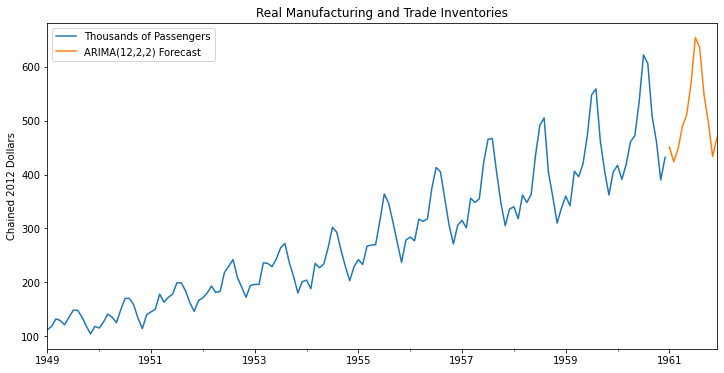

In [137]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = ts_data.plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

## <font color=red> 6.6. Continously retrain model

In [138]:
historical = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = sm.tsa.ARIMA(historical, order=(12,2,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    observed = test[t]
    historical.append(observed)
    print('Predicted value = %f, Expected value = %f' % (yhat, observed))

Printing Predicted vs Expected Values...


Predicted value = 341.821050, Expected value = 337.000000
Predicted value = 346.209604, Expected value = 360.000000
Predicted value = 333.748083, Expected value = 342.000000
Predicted value = 382.117870, Expected value = 406.000000
Predicted value = 384.704138, Expected value = 396.000000
Predicted value = 412.791413, Expected value = 420.000000
Predicted value = 483.133135, Expected value = 472.000000
Predicted value = 525.397420, Expected value = 548.000000
Predicted value = 556.445887, Expected value = 559.000000
Predicted value = 459.252773, Expected value = 463.000000
Predicted value = 417.000564, Expected value = 407.000000
Predicted value = 352.645674, Expected value = 362.000000
Predicted value = 389.331630, Expected value = 405.000000
Predicted value = 418.276294, Expected value = 417.000000
Predicted value = 400.646725, Expected value = 391.000000
Predicted value = 445.265076, Expected value = 419.000000
Predicted value = 414.814224,

311.066380076472


[]

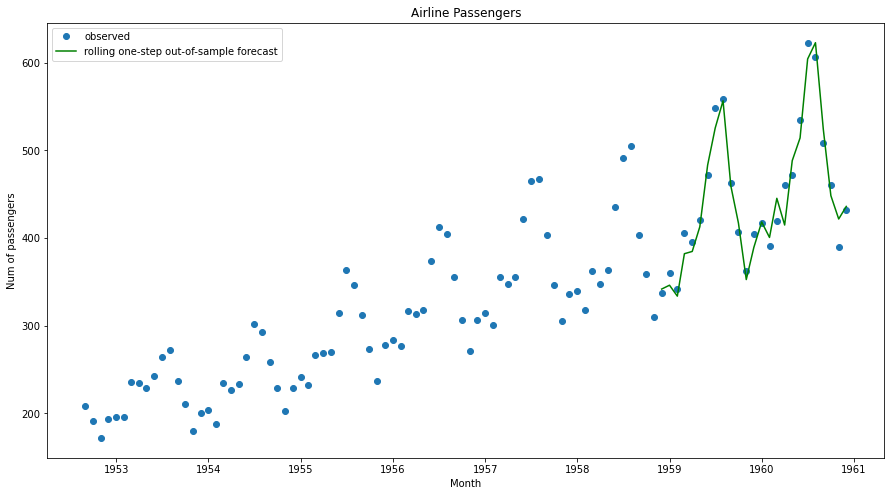

In [139]:
# calculate error
from sklearn.metrics import mean_squared_error    
error = mean_squared_error(test, predictions)
print(error)

# visualize time series forecast
predictions_series = pd.Series(predictions, index = test.index)
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title='Airline Passengers', xlabel='Month', ylabel='Num of passengers')
ax.plot(ts_data[-100:], 'o', label='observed')
ax.plot(predictions_series, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.plot()

In [140]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions_series)
print(f'ARIMA(12,2,2) MSE Error: {error:11.10}')

ARIMA(12,2,2) MSE Error: 311.0663801


In [141]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions_series)
print(f'ARIMA(12,2,2) RMSE Error: {error:11.10}')

ARIMA(12,2,2) RMSE Error: 17.63707402


### <font color=blue>5. Perform and visualize forecast

In [142]:
historical = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = sm.tsa.ARIMA(historical, order=(12,2,12))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    observed = test[t]
    historical.append(yhat)
    print('Predicted value = %f, Expected value = %f' % (yhat, observed))

Printing Predicted vs Expected Values...


Predicted value = 346.022862, Expected value = 337.000000
Predicted value = 354.293859, Expected value = 360.000000
Predicted value = 319.266890, Expected value = 342.000000
Predicted value = 357.646345, Expected value = 406.000000
Predicted value = 332.788574, Expected value = 396.000000
Predicted value = 362.390370, Expected value = 420.000000
Predicted value = 428.113226, Expected value = 472.000000
Predicted value = 496.887951, Expected value = 548.000000
Predicted value = 503.510365, Expected value = 559.000000
Predicted value = 411.084438, Expected value = 463.000000
Predicted value = 360.536495, Expected value = 407.000000
Predicted value = 319.116225, Expected value = 362.000000
Predicted value = 346.312845, Expected value = 405.000000
Predicted value = 351.329488, Expected value = 417.000000
Predicted value = 324.670749, Expected value = 391.000000
Predicted value = 351.451981, Expected value = 419.000000
Predicted value = 331.578202,

[]

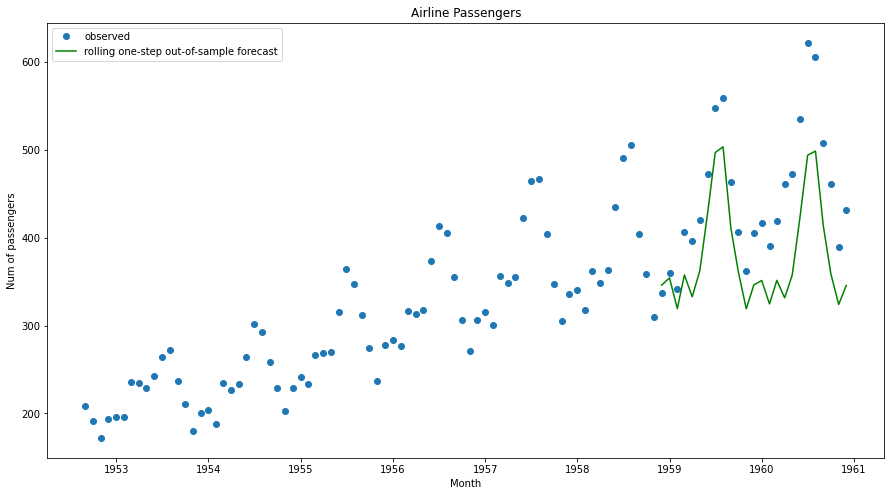

In [143]:
# calculate error
from sklearn.metrics import mean_squared_error    
error = mean_squared_error(test, predictions)

# visualize time series forecast
predictions_series = pd.Series(predictions, index = test.index)
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title='Airline Passengers', xlabel='Month', ylabel='Num of passengers')
ax.plot(ts_data[-100:], 'o', label='observed')
ax.plot(predictions_series, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.plot()

In [144]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions_series)
print(f'ARIMA(12,2,2) MSE Error: {error:11.10}')

ARIMA(12,2,2) MSE Error: 5701.893688


In [145]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions_series)
print(f'ARIMA(12,2,2) RMSE Error: {error:11.10}')

ARIMA(12,2,2) RMSE Error: 75.51088457


## <font color=red> 6.7. SARIMA

In [106]:
from pmdarima import auto_arima    
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(train,seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  119
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -396.839
Date:                            Fri, 15 Jul 2022   AIC                            801.679
Time:                                    15:20:42   BIC                            812.370
Sample:                                         0   HQIC                           806.013
                                            - 119                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.5597      2.054      2.220      0.026       0.533       8.586
ar.L1          0.6701      0.100      6.694      0.000       0.474       0.866
ar.L2          0.1562      0.097      1.614      0.106      -0.033       0.346
sigma2        96.5155     11.915      8.101      0.000      73.163     119.868
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.92   Prob(JB):                         0.45
Heteroskedasticity (H):               1.47   Skew:                             0.00
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [108]:
# We have seasonal data!
model = sm.tsa.statespace.SARIMAX(train,order=(2,0,0), seasonal_order=(0,1,0,12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:            Thousands of Passengers   No. Observations:                  119
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -399.756
Date:                            Fri, 15 Jul 2022   AIC                            805.512
Time:                                    15:21:29   BIC                            813.531
Sample:                                01-01-1949   HQIC                           808.763
                                     - 11-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7295      0.089      8.205      0.000       0.555       0.904
ar.L2          0.2223      0.093   

In [109]:
# We have seasonal data!
model = sm.tsa.statespace.SARIMAX(train,order=(0,1,1), seasonal_order=(2,1,0,12))
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:             Thousands of Passengers   No. Observations:                  119
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -395.376
Date:                             Fri, 15 Jul 2022   AIC                            798.752
Time:                                     15:21:39   BIC                            809.406
Sample:                                 01-01-1949   HQIC                           803.070
                                      - 11-01-1958                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2782      0.082     -3.391      0.001      -0.439      -0.117
ar.S.L12      -0.0370      

### <font color=blue> Prediction of Future Values

Firts we can get an idea of how well our model performs by just predicting for values that we actually already know:

In [110]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

In [111]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test[i]}")

predicted=341.9912039666562, expected=337
predicted=346.63187312333037, expected=360
predicted=323.8637205731295, expected=342
predicted=370.5497244879303, expected=406
predicted=356.1635701601186, expected=396
predicted=371.1718823709637, expected=420
predicted=444.6587661644855, expected=472
predicted=500.7862495580122, expected=548
predicted=515.8624943493778, expected=559
predicted=414.29112311031446, expected=463
predicted=367.6319426799996, expected=407
predicted=317.82683713918664, expected=362
predicted=349.17354088348367, expected=405
predicted=353.03069505947, expected=417
predicted=329.0751835002763, expected=391
predicted=373.9902827910467, expected=419
predicted=358.7065896132586, expected=461
predicted=374.9303392060235, expected=472
predicted=449.1221185360377, expected=535
predicted=507.2204759192451, expected=622
predicted=524.0805670613928, expected=606
predicted=416.7555231192591, expected=508
predicted=371.9812711822633, expected=461
predicted=321.14214022384374, ex

[]

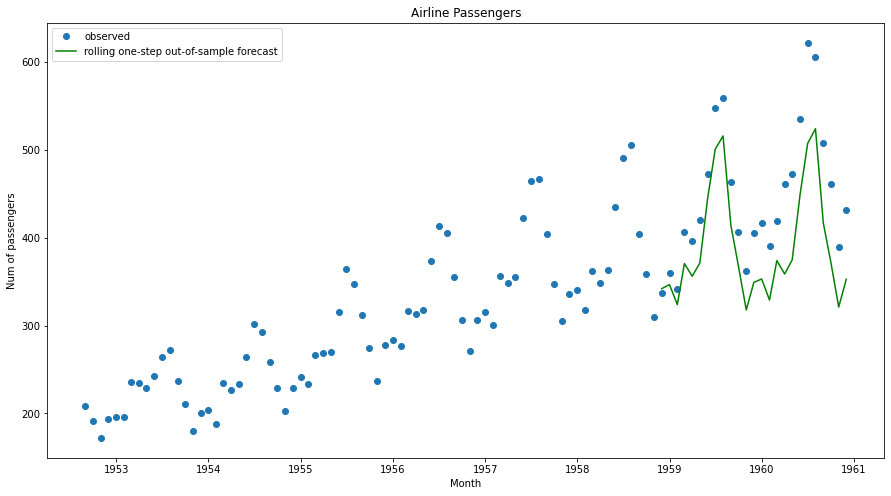

In [112]:
# visualize time series forecast
predictions_series = pd.Series(predictions, index = test.index)
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title='Airline Passengers', xlabel='Month', ylabel='Num of passengers')
ax.plot(ts_data[-100:], 'o', label='observed')
ax.plot(predictions_series, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.plot()

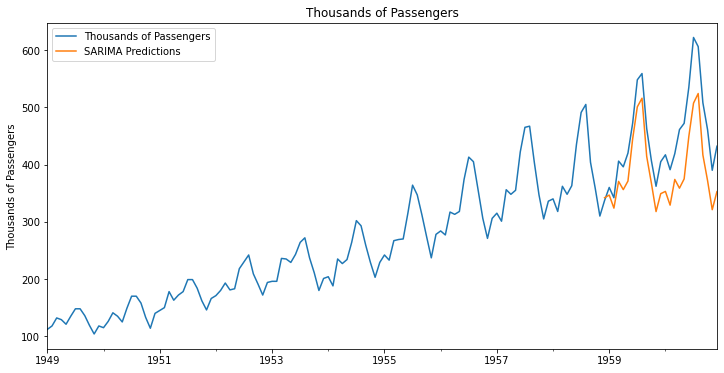

In [113]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'Thousands of Passengers'
ylabel='Thousands of Passengers'
xlabel='' # we don't really need a label here

ax = ts_data.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Evaluate the Model

In [114]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 4158.920733


In [115]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 64.48969478


These are outstanding results!
### Retrain the model on the full data, and forecast the future

In [117]:
model = sm.tsa.statespace.SARIMAX(ts_data,order=(0,1,1), seasonal_order=(2,1,0,12))
results = model.fit()
fcast = results.predict(len(ts_data),len(ts_data)+11,typ='levels').rename('SARIMA Forecast')

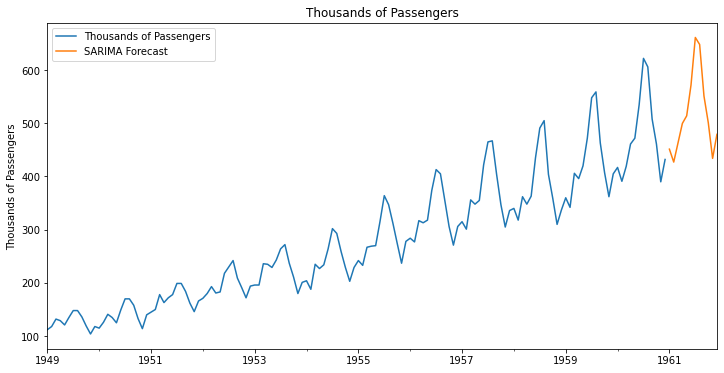

In [118]:
# Plot predictions against known values
title = 'Thousands of Passengers'
ylabel='Thousands of Passengers'
xlabel=''

ax = ts_data.plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);